In [24]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


# Toy model

The equation to solve:

$\mathbf{A}\vec{x}=\vec{\gamma}$,

where $\vec{x}$ is the parameter to solve and $\vec{\gamma}$ is the observed data
and $\mathbf{A}$ is the transform matrix.

We use a simple steup

In [322]:
A=np.matrix([[1,0.6],[0.5,1.]])
print('The trasfrom matrix is \n',A)
A.T*A

The trasfrom matrix is 
 [[1.  0.6]
 [0.5 1. ]]


matrix([[1.25, 1.1 ],
        [1.1 , 1.36]])

In [317]:
xt=np.matrix([1,0.]).T*8.
print('The true vector x is: \n',xt)

gammat=np.matrix([1,0.5]).T*8
print('And the corresponding true gamma is: \n',gammat)

The true vector x is: 
 [[8.]
 [0.]]
And the corresponding true gamma is: 
 [[8.]
 [4.]]


Note that though the setup is simple, it catches the difficult we have in the weak lensing mass map 
reconstruction. The lensing kernels of two lens plane are highly correlate and, in our toy model. the 
column vectors of $\mathbf{A}$ are highly correlated

Here the observed $\gamma$ is further comtaminated with error. The error includes statistical error mainly
caused by shape noise and systematic error. We assume that the error follows a zero-mean normal
distribution. And we make $500$ realization of the error. 

In [318]:
gamma=gammat+np.matrix(np.random.randn(2)).T
print('The final observed gamma is:\n',gamma)

The final observed gamma is:
 [[7.8767181 ]
 [4.70052427]]


# Solving $x$
## 1. $\chi^2 fitting$
We first consider the normal $\chi^2$ fitting.
$$\rm{min}{(||\gamma-\mathbf{A}x||_2^2)}$$
The estimated $x$ should be
$$\vec{x}=(\mathbf{A}^T \mathbf{A})^{-1} \mathbf{A}^T \vec{\gamma}$$
In this simple case $\mathbf{A}$ is invertible, so we directly have
$$\vec{x}=\mathbf{A}^{-1} \vec{\gamma}.$$

In [319]:
AI=np.linalg.inv(A)
print('the inverse of transform matrix A is:\n', AI)
def solve_ch2(B,d):
    BI=np.linalg.inv(B)
    return BI.dot(d)

the inverse of transform matrix A is:
 [[ 1.42857143 -0.85714286]
 [-0.71428571  1.42857143]]


The average first component of x is: 7.9857751778074855
The average second component of x is: 0.015933285733348596


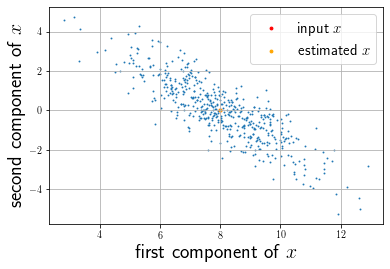

In [320]:
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_ch2(A,gamma)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([8],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)
xp=np.linspace(x_est_array_0.min(),x_est_array_0.max(),20)
if False:
    plt.plot(xp,xp,c='black',ls='-.')
    plt.plot(xp,-xp,c='black',ls='--')

## Comments
+ we have an accurate estimation of $x$ even though the precision is really bad.

+ The noise on the reconstructed $x$ field is anti-correlated. 

(I said the noise is correlated in the presentation, and it should be incorrect.)

# 2. Sparsity Regression
We then consider the $\chi^2$ fitting with sparsity reularization.
$$\rm{min}{(||\gamma-\mathbf{A}x||_2^2+\lambda|x|^1_1}).$$
The estimated $x$ should be
$$\vec{x}^{(n+1)}=S_\lambda(\vec{x}^{(n)}+\mathbf{A}^T (\vec{\gamma}-\mathbf{A}\vec{x}^{(n)})),$$
where $S_\lambda$ is the soft-thresholding function.

In [321]:
def soft_thresholding(dum,thresholds):
    # Standard Threshold Function
    return np.multiply(np.sign(dum),np.maximum(np.abs(dum)-thresholds,0.))
def solve_lasso(B,d,lbd):
    x=np.matrix(np.zeros(2)).T
    mu=1/1.6/1.5
    tn=0
    for i in range(20):
        BT=B.T
        g=BT.dot((d-B.dot(x)))
        tmp=x+mu*g
        tmp=soft_thresholding(tmp,lbd)
        
        tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
        ratio= (tn-1.)/tnTmp
        tn   = tnTmp
        x    = tmp+(ratio*(tmp-x))
        #x    = tmp
    return x

The average first component of x is: 2.1531678386416098
The average second component of x is: 0.06246417442339058


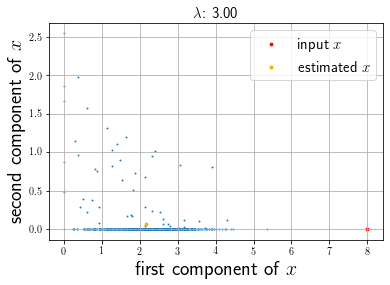

In [309]:
lbd=3
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_lasso(A,gamma,lbd)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([8],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
plt.title(r'$\lambda$: %.2f' %lbd,fontsize=15)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)

The average first component of x is: 3.983723995237001
The average second component of x is: 0.19015200258691048


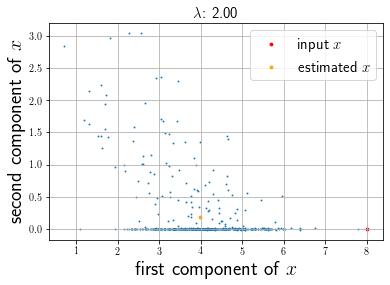

In [312]:
lbd=2
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_lasso(A,gamma,lbd)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([8],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
plt.title(r'$\lambda$: %.2f' %lbd,fontsize=15)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)

## Comments
+ The estimated $\vec{x}$ is biased.
    + The first component of $\vec{x}$ is biased to be closer to zero
    + The second component of $\vec{x}$ is biased to be correlated with the first component of $\vec{x}$
+ The scatter on the estimation is smaller
+ The estimation is sparse.
+ We exchange accuracy for precision by adding prior

# 3. Ridge Regression
We then consider the $\chi^2$ fitting with ridge reularization.
$$\rm{min}{(||\vec{\gamma}-\mathbf{A}\vec{x}||_2^2+\tau^2||\vec{x}||^2_2}).$$
The estimated $x$ is
$$\vec{x}=(\mathbf{A}^T \mathbf{A}+\tau^2)^{-1}\mathbf{A}^T \vec{\gamma},$$

In [273]:
def solve_ridge(B,d,tau):
    BTB=B.T*B
    Inv=np.linalg.inv(BTB+tau**2.*np.matrix(np.eye(2)))
    return Inv*B.T*d
if False:
    tau=3.
    print(np.linalg.inv(A.T*A+tau**2.*np.matrix(np.eye(2)))*A.T)
    print(np.linalg.inv(A.T*A+tau**2.*np.matrix(np.eye(2))))

The average first component of x is: 0.110678052004704
The average second component of x is: 0.09186578237097717


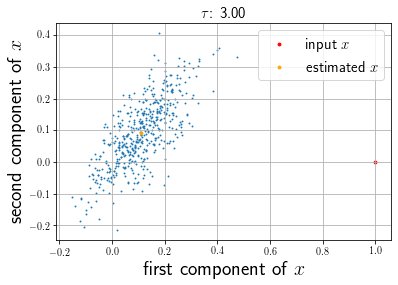

In [271]:
tau=3.
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_ridge(A,gamma,tau)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([1],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
plt.title(r'$\tau$: %.2f' %tau,fontsize=15)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)

The average first component of x is: 0.11827133362357603
The average second component of x is: 0.09930777639435341


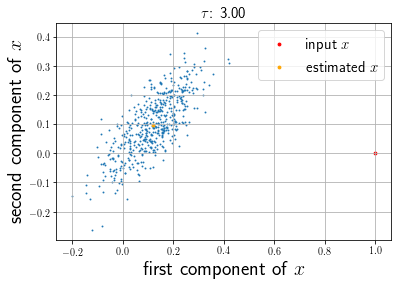

In [157]:
tau=3.
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_ridge(A,gamma,tau)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([1],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
plt.title(r'$\tau$: %.2f' %tau,fontsize=15)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)

## Comments
+ The estimated $\vec{x}$ is biased.
    + The first component of $\vec{x}$ is biased to be closer to zero
    + The second component of $\vec{x}$ is biased to be correlated with the first component of $\vec{x}$
+ The scatter on the estimation is smaller
+ The covariance of noise changes

# 4. Expectation Path
In this section, we show the change of the expectation of the estimator as the regularization term changes.

Text(0.5, 1.0, 'expectation path of sparsity')

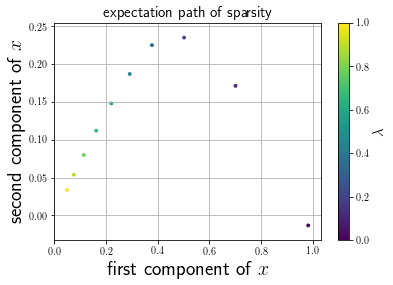

In [177]:
nsample=500
npath=10
lbdlist=np.linspace(0.,1.,10)
x_est_array_0=np.zeros((nsample,npath))
x_est_array_1=np.zeros((nsample,npath))
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    for ip,lbd in enumerate(lbdlist): 
        x_est=solve_lasso(A,gamma,lbd)
        x_est_array_0[i,ip]=x_est[0]
        x_est_array_1[i,ip]=x_est[1]
x0_ave=np.average(x_est_array_0,axis=0)
x1_ave=np.average(x_est_array_1,axis=0)
mb=plt.scatter(x0_ave,x1_ave,s=8,c=lbdlist)
cb=plt.colorbar(mb)
cb.set_label(r'$\lambda$',fontsize=15)
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
plt.title('expectation path of sparsity',fontsize=15)

Text(0.5, 1.0, 'expectation path of sparsity')

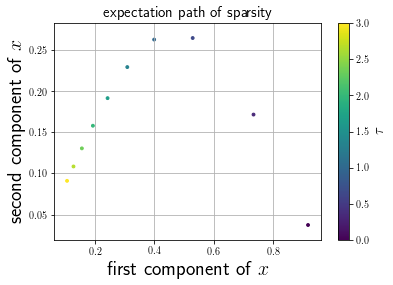

In [178]:
nsample=500
npath=10
lbdlist=np.linspace(0.,3.,10)
x_est_array_0=np.zeros((nsample,npath))
x_est_array_1=np.zeros((nsample,npath))
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    for ip,lbd in enumerate(lbdlist): 
        x_est=solve_ridge(A,gamma,lbd)
        x_est_array_0[i,ip]=x_est[0]
        x_est_array_1[i,ip]=x_est[1]
x0_ave=np.average(x_est_array_0,axis=0)
x1_ave=np.average(x_est_array_1,axis=0)
mb=plt.scatter(x0_ave,x1_ave,s=8,c=lbdlist)
cb=plt.colorbar(mb)
cb.set_label(r'$\tau$',fontsize=15)
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
plt.title('expectation path of sparsity',fontsize=15)

# 5. Correlated Ridge Regression
We then consider the $\chi^2$ fitting with ridge reularization.
$$\rm{min}{(||\vec{\gamma}-\mathbf{A}\vec{x}||_2^2+||\mathbf{T}\vec{x}||^2_2}).$$
The estimated $x$ is
$$\vec{x}=(\mathbf{A}^T \mathbf{A}+\mathbf{T}^T \mathbf{T})^{-1}\mathbf{A}^T \vec{\gamma},$$

In [254]:
def solve_ridge_anti(B,d,tau,cov=1.):
    D=np.matrix(np.eye(2)+cov*np.array([[0,1],[1,0]]))
    DTD=D.T*D
    BTB=B.T*B
    Inv=np.linalg.inv(BTB+tau**2.*DTD)
    return Inv*B.T*d

The matrix T is: 
 [[1.  0.3]
 [0.3 1. ]]
The average first component of x is: 0.3969110297647119
The average second component of x is: 0.14480660202084397


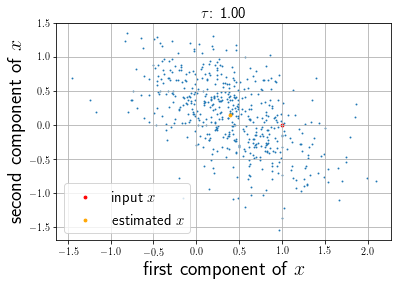

In [296]:
tau=1.
cov=.3
D=np.matrix(np.eye(2)+cov*np.array([[0,1],[1,0]]))*tau
print('The matrix T is: \n',D)
nsample=500
x_est_array_0=np.zeros(nsample)
x_est_array_1=np.zeros(nsample)
sigma_noi=1.
for i in range(nsample):
    gamma=gammat+np.matrix(np.random.randn(2)*sigma_noi).T
    x_est=solve_ridge_anti(A,gamma,tau,cov)
    x_est_array_0[i]=x_est[0]
    x_est_array_1[i]=x_est[1]
plt.scatter(x_est_array_0,x_est_array_1,s=0.8)
plt.scatter([1],[0],s=8.,c='red',label=r'input $x$')
plt.grid()
plt.xlabel(r'first component of $x$',fontsize=20)
plt.ylabel(r'second component of $x$',fontsize=20)
x0_ave=np.average(x_est_array_0)
x1_ave=np.average(x_est_array_1)
plt.title(r'$\tau$: %.2f' %tau,fontsize=15)
print('The average first component of x is:', x0_ave)
print('The average second component of x is:', x1_ave)
plt.scatter([x0_ave],[x1_ave],s=8.,c='orange',label=r'estimated $x$')
plt.legend(fontsize=15)